## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
import random

## Load MIMIC III Data

Load MIMIC data from google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_mimic_data():
    admissions = pd.read_csv(os.path.join(DATA_PATH, 'ADMISSIONS.csv.gz'))
    diagnoses = pd.read_csv(os.path.join(DATA_PATH, 'DIAGNOSES_ICD.csv.gz'))
    labevents = pd.read_csv(os.path.join(DATA_PATH, 'LABEVENTS.csv.gz'))
    return admissions, diagnoses, labevents

In [ ]:
# Load relevant MIMIC-III data
DATA_PATH = "/content/drive/MyDrive/data"
admissions, diagnoses, labevents = load_mimic_data()

## Data preprocessing and Feature Engineering

In [ ]:
def preprocess_features(labevents):
    top_items = labevents['ITEMID'].value_counts().nlargest(20).index.tolist()
    filtered = labevents[labevents['ITEMID'].isin(top_items)]
    pivot = filtered.pivot_table(
        index='SUBJECT_ID',
        columns='ITEMID',
        values='VALUENUM',
        aggfunc='mean'
    ).fillna(0)
    return pivot

In [ ]:
features_df = preprocess_features(labevents).reset_index()

In [ ]:
# Extract diagnosis code list per subject
def get_diagnosis_labels(diagnoses):
    grouped = diagnoses.groupby('SUBJECT_ID')['ICD9_CODE'].apply(list)
    return grouped

In [ ]:
diagnosis_df = get_diagnosis_labels(diagnoses).reset_index()

In [ ]:
# Merge outcomes
merged = pd.merge(features_df, admissions[['SUBJECT_ID', 'HOSPITAL_EXPIRE_FLAG', 'DISCHARGE_LOCATION']], on='SUBJECT_ID')
merged = pd.merge(merged, diagnosis_df, on='SUBJECT_ID')

In [ ]:
X = merged.drop(columns=['SUBJECT_ID', 'HOSPITAL_EXPIRE_FLAG', 'DISCHARGE_LOCATION', 'ICD9_CODE']).values
y_mortality = merged['HOSPITAL_EXPIRE_FLAG'].values
y_discharge = merged['DISCHARGE_LOCATION'].values
y_diagnosis = merged['ICD9_CODE'].values

## Contrasting Learning - Embeddings

In [ ]:
class ContrastivePatientDataset(Dataset):
    def __init__(self, features):
        self.features = features

    def __getitem__(self, index):
        x1 = self.features[index]
        x2 = self._augment(x1)
        return torch.tensor(x1).float(), torch.tensor(x2).float()

    def __len__(self):
        return len(self.features)

    def _augment(self, x):
        noise = np.random.normal(0, 0.01, size=x.shape)
        return x + noise

# Encoder model
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, x):
        return self.net(x)

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)
        logits = torch.matmul(z_i, z_j.T) / self.temperature
        labels = torch.arange(len(z_i)).to(z_i.device)
        return nn.CrossEntropyLoss()(logits, labels)

# Train contrastive model
def train_contrastive_model(data):
    model = Encoder(input_dim=data.shape[1], hidden_dim=128)
    loss_fn = ContrastiveLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    dataset = ContrastivePatientDataset(data)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    for epoch in range(10):
        for x1, x2 in loader:
            z1 = model(x1)
            z2 = model(x2)
            loss = loss_fn(z1, z2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return model

In [ ]:
model = train_contrastive_model(X)

Epoch 1, Loss: 2.3714
Epoch 2, Loss: 2.3621
Epoch 3, Loss: 2.3277
Epoch 4, Loss: 2.3381
Epoch 5, Loss: 2.3107
Epoch 6, Loss: 2.3061
Epoch 7, Loss: 2.3193
Epoch 8, Loss: 2.3114
Epoch 9, Loss: 2.2965
Epoch 10, Loss: 2.3169


In [ ]:
embeddings = model(torch.tensor(X).float()).detach().numpy()

### Task 1 : Mortality Prediction

Predicting whether a patient will die during the hospital stay based on early or real-time clinical data (e.g., labs, vitals, history).

1. Supports early warning systems in ICUs.

2. Enables timely interventions or palliative care discussions.

3. Helps hospitals optimize resource allocation for high-risk patients.

In [ ]:
# Mortality Prediction Task
def mortality_prediction(embeddings, labels):
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    proba = clf.predict_proba(X_test)[:, 1]
    print("\nMortality Prediction Report:")
    print(classification_report(y_test, preds))
    print("ROC AUC:", roc_auc_score(y_test, proba))

In [ ]:
mortality_prediction(embeddings, y_mortality)


Mortality Prediction Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     10454
           1       0.49      0.22      0.30      1130

    accuracy                           0.90     11584
   macro avg       0.70      0.60      0.62     11584
weighted avg       0.88      0.90      0.88     11584

ROC AUC: 0.7864491467888819


### Task 2 : Discharge Disposition

Predicting the destination of a patient after hospital discharge (e.g., home, rehab, hospice, expired).

1. Helps plan post-discharge care and support systems.

2. Aids case managers in coordinating transfers or follow-ups.

3. Identifies patients likely to need intensive rehabilitation or home care services.

In [ ]:
# Discharge Disposition Task
def discharge_prediction(embeddings, dispositions):
    le = LabelEncoder()
    labels = le.fit_transform(dispositions)
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print("\nDischarge Disposition Prediction Report:")
    print(classification_report(y_test, preds))

In [ ]:
discharge_prediction(embeddings, y_discharge)


Discharge Disposition Prediction Report:
              precision    recall  f1-score   support

           0       0.40      0.39      0.40      1135
           1       0.16      0.06      0.08       140
           2       0.00      0.00      0.00         4
           3       0.41      0.08      0.13        89
           4       0.53      0.66      0.59      3615
           5       0.36      0.41      0.39      2869
           6       0.00      0.00      0.00        12
           7       0.05      0.01      0.02        81
           8       0.00      0.00      0.00        32
           9       0.00      0.00      0.00        11
          10       0.23      0.11      0.15        64
          11       0.29      0.18      0.22       437
          12       0.00      0.00      0.00         9
          13       0.29      0.20      0.23      1271
          14       0.33      0.16      0.21       284
          15       0.33      0.27      0.30      1531

    accuracy                          

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# t-SNE Visualization
def visualize_embeddings(embeddings, labels, title="t-SNE Visualization"):
    tsne = TSNE(n_components=2)
    reduced = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.title(title)
    plt.show()

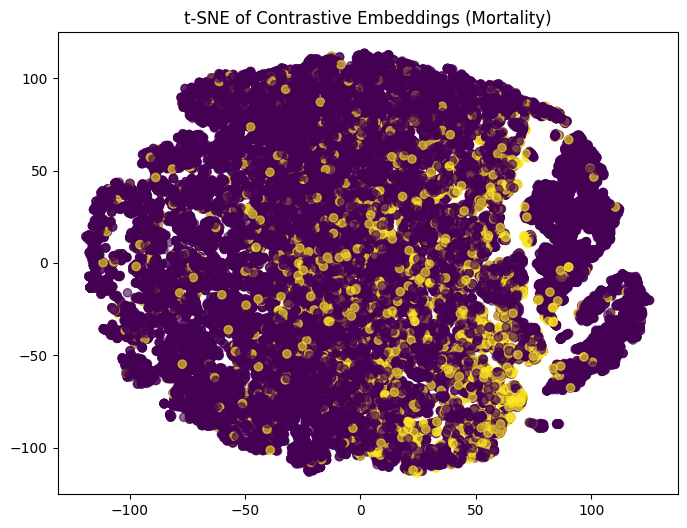

In [ ]:
visualize_embeddings(embeddings, y_mortality, title="t-SNE of Contrastive Embeddings (Mortality)")